In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm

#tensorflow deep learning basics
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L

#for model evaluation
from sklearn.model_selection import train_test_split, KFold,  StratifiedKFold

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
#get comp data
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
sample_sub = pd.read_csv("sample_submission.csv")

In [ ]:
#target columns
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [ ]:
#label encoding all the data inputs 
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def get_pair_index_structure(structure):
    structure = np.array([struc for struc in structure], dtype="<U4")

    open_index = np.where(structure == "(")[0]
    closed_index = np.where(structure == ")")[0]

    structure[open_index] = range(0, len(open_index))
    structure[closed_index] = range(len(open_index)-1, -1, -1)
    structure[structure == "."] = -1
    structure = structure.astype(int)

    pair_structure = np.array([-1]*len(structure))
    for i in range(len(open_index)):
        start, end = np.where(structure == i)[0]
        pair_structure[start] = end
        pair_structure[end] = start    
        
    return pair_structure

In [ ]:
#Converting the input variables into a matrix
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

train_inputs_all = preprocess_inputs(train)
train_labels_all = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))

In [ ]:
# custom loss_fnc
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def build_model(model_type=1,seq_len=107, pred_len=68, dropout=0.4,
                embed_dim=100, hidden_dim=128):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    if model_type == 0:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif model_type == 1:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    elif model_type == 2:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    elif model_type == 3:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)

    elif model_type == 4:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    #only making predictions on the first part of each sequence
    truncated = hidden[:, :pred_len]

    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    adam = tf.optimizers.Adam()
    model.compile(optimizer=adam, loss=MCRMSE)
    
    return model

Model: model_1
Fold: 1
model_1 Min training loss=0.35703355073928833, min validation loss=0.3660884499549866
94/94 [==============================] - 3s 14ms/step
Fold: 2
model_1 Min training loss=0.35440537333488464, min validation loss=0.38181769847869873
94/94 [==============================] - 3s 17ms/step
Fold: 3
model_1 Min training loss=0.3574508726596832, min validation loss=0.3802618086338043
94/94 [==============================] - 3s 14ms/step
Fold: 4
model_1 Min training loss=0.34557875990867615, min validation loss=0.41213133931159973
94/94 [==============================] - 3s 15ms/step
Fold: 5
model_1 Min training loss=0.3682273030281067, min validation loss=0.3974454998970032
94/94 [==============================] - 3s 14ms/step
Mean Validation loss: 0.3875489592552185


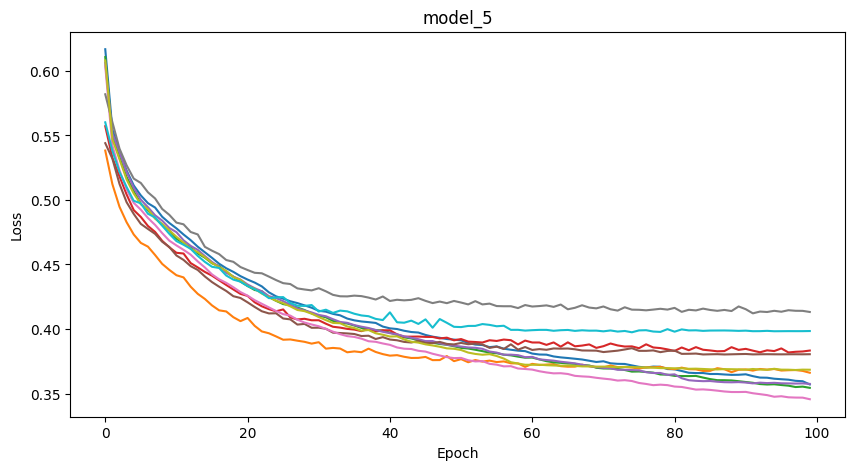

Model: model_2
Fold: 1
model_2 Min training loss=0.3524050712585449, min validation loss=0.37254494428634644
94/94 [==============================] - 3s 16ms/step
Fold: 2
model_2 Min training loss=0.3489554822444916, min validation loss=0.38713714480400085
94/94 [==============================] - 3s 16ms/step
Fold: 3
model_2 Min training loss=0.3438194692134857, min validation loss=0.38503265380859375
94/94 [==============================] - 4s 18ms/step
Fold: 4
model_2 Min training loss=0.3426157832145691, min validation loss=0.4173920452594757
94/94 [==============================] - 3s 17ms/step
Fold: 5
model_2 Min training loss=0.35344773530960083, min validation loss=0.39953798055648804
94/94 [==============================] - 3s 16ms/step
Mean Validation loss: 0.39232895374298093


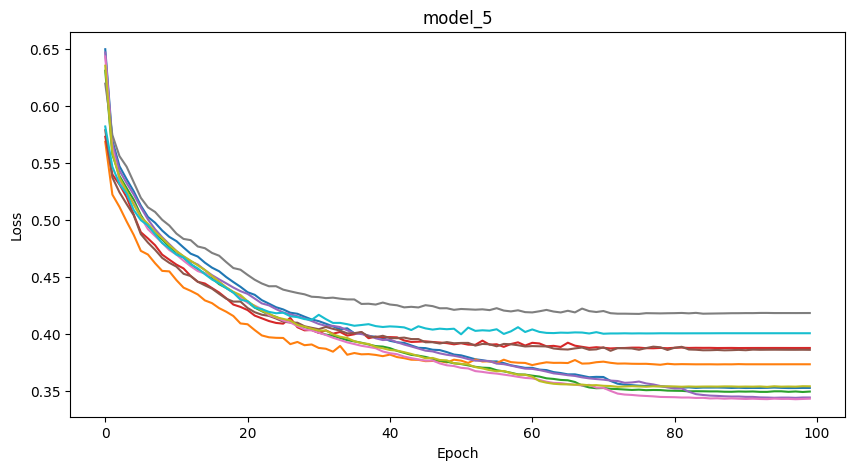

Model: model_3
Fold: 1
model_3 Min training loss=0.33891361951828003, min validation loss=0.3688601553440094
94/94 [==============================] - 3s 16ms/step
Fold: 2
model_3 Min training loss=0.3353514075279236, min validation loss=0.38405922055244446
94/94 [==============================] - 4s 16ms/step
Fold: 3
model_3 Min training loss=0.35647884011268616, min validation loss=0.3813849687576294
94/94 [==============================] - 3s 16ms/step
Fold: 4
model_3 Min training loss=0.333952933549881, min validation loss=0.4145732522010803
94/94 [==============================] - 3s 16ms/step
Fold: 5
model_3 Min training loss=0.3584960103034973, min validation loss=0.397969126701355
94/94 [==============================] - 3s 16ms/step
Mean Validation loss: 0.3893693447113037


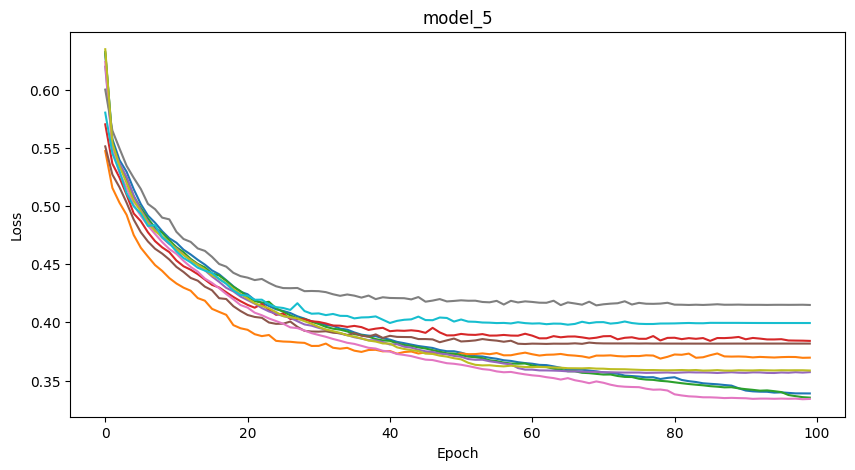

Model: model_4
Fold: 1
model_4 Min training loss=0.3520664870738983, min validation loss=0.36591625213623047
94/94 [==============================] - 3s 15ms/step
Fold: 2
model_4 Min training loss=0.34955355525016785, min validation loss=0.37975576519966125
94/94 [==============================] - 3s 16ms/step
Fold: 3
model_4 Min training loss=0.34866422414779663, min validation loss=0.3790033757686615
94/94 [==============================] - 3s 15ms/step
Fold: 4
model_4 Min training loss=0.340411514043808, min validation loss=0.4105553925037384
94/94 [==============================] - 3s 16ms/step
Fold: 5
model_4 Min training loss=0.34969621896743774, min validation loss=0.3936888575553894
94/94 [==============================] - 3s 16ms/step
Mean Validation loss: 0.3857839286327362


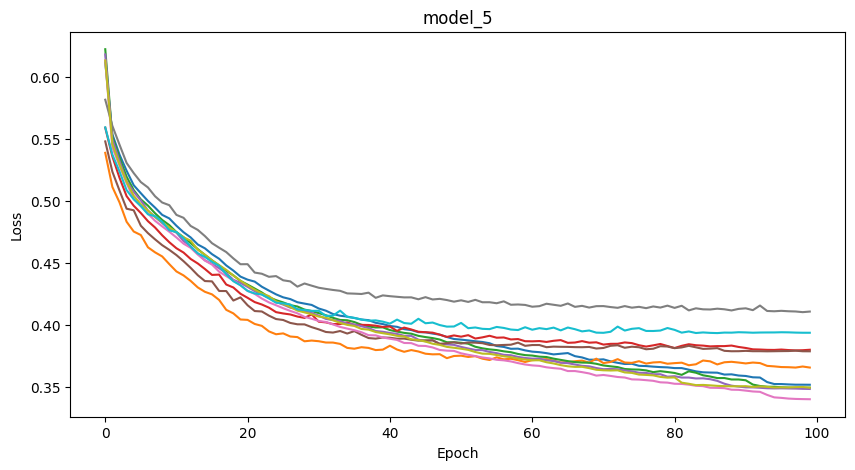

Model: model_5
Fold: 1
model_5 Min training loss=0.3551301658153534, min validation loss=0.36813393235206604
94/94 [==============================] - 6s 17ms/step
Fold: 2
model_5 Min training loss=0.34176012873649597, min validation loss=0.3815523386001587
94/94 [==============================] - 4s 17ms/step
Fold: 3
model_5 Min training loss=0.34398549795150757, min validation loss=0.3812839090824127
94/94 [==============================] - 3s 17ms/step
Fold: 4
model_5 Min training loss=0.33494722843170166, min validation loss=0.4137604832649231
94/94 [==============================] - 4s 17ms/step
Fold: 5
model_5 Min training loss=0.3503107726573944, min validation loss=0.3959348499774933
94/94 [==============================] - 3s 17ms/step
Mean Validation loss: 0.3881331026554108


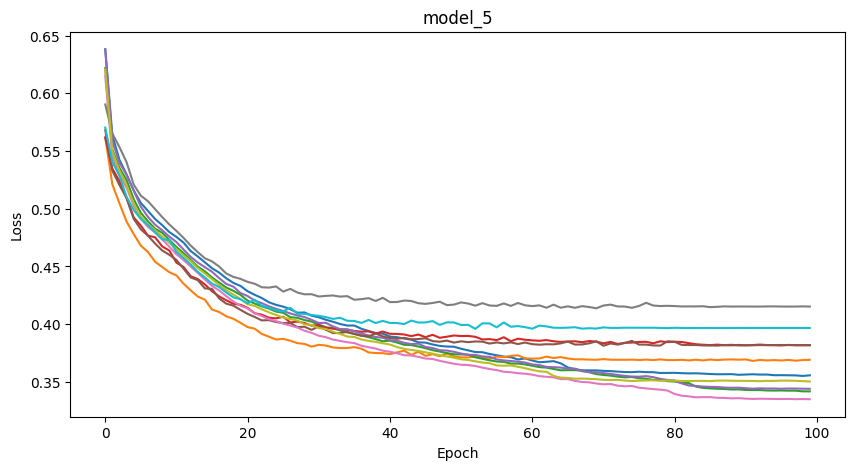

In [ ]:
#model building using K- fold technique for better parameters
def train_and_predict(n_folds=5, model_name="model", model_type=0, epochs=90, debug=False):

    print("Model:", model_name)

    ensemble_preds = pd.DataFrame(index=sample_sub.index, columns=target_cols).fillna(0) # test dataframe with 0 values
    kf = KFold(n_folds, shuffle=True, random_state=42)
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=42)
    val_losses = []
    historys = []

    for i, (train_index, val_index) in enumerate(skf.split(train_inputs_all, train['SN_filter'])):
        print("Fold:", str(i+1))

        model_train = build_model(model_type=model_type)
        model_short = build_model(model_type=model_type, seq_len=107, pred_len=107)
        model_long = build_model(model_type=model_type, seq_len=130, pred_len=130)

        train_inputs, train_labels = train_inputs_all[train_index], train_labels_all[train_index]
        val_inputs, val_labels = train_inputs_all[val_index], train_labels_all[val_index]

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5')

        history = model_train.fit(
            train_inputs , train_labels, 
            validation_data=(val_inputs,val_labels),
            batch_size=64,
            epochs=epochs, # changed 70
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(), checkpoint],
            verbose=0
        )

        print(f"{model_name} Min training loss={min(history.history['loss'])}, min validation loss={min(history.history['val_loss'])}")

        val_losses.append(min(history.history['val_loss']))
        historys.append(history)

        model_short.load_weights(f'{model_name}.h5')
        model_long.load_weights(f'{model_name}.h5')

        public_preds = model_short.predict(public_inputs)
        private_preds = model_long.predict(private_inputs)

        preds_model = []
        for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
            for i, uid in enumerate(df.id):
                single_pred = preds[i]

                single_df = pd.DataFrame(single_pred, columns=target_cols)
                single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

                preds_model.append(single_df)

        preds_model_df = pd.concat(preds_model)
        ensemble_preds[target_cols] += preds_model_df[target_cols].values / n_folds
        """
        if debug:
            print("Intermediate ensemble result")
            print(ensemble_preds[target_cols].head())
        """
    ensemble_preds["id_seqpos"] = preds_model_df["id_seqpos"].values
    ensemble_preds = pd.merge(sample_sub["id_seqpos"], ensemble_preds, on="id_seqpos", how="left")

    print("Mean Validation loss:", str(np.mean(val_losses)))

    if debug:
        fig, ax = plt.subplots(1, 1, figsize = (10, 5))
        for i, history in enumerate(historys):
            ax.plot(history.history['loss'])
            ax.plot(history.history['val_loss'])
            ax.set_title('model_'+str(i+1))
            ax.set_ylabel('Loss')
            ax.set_xlabel('Epoch')
        plt.show()

    return ensemble_preds


public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()
public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

ensembles = []

for i in range(5):
    model_name = "model_"+str(i+1)

    ensemble = train_and_predict(n_folds=5, model_name=model_name, model_type=i, epochs=100,debug=True)
    ensembles.append(ensemble)